# Import Necessary Libraries

In [1]:
try:
    import google.colab  # Check if running in Google Colab
    !apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
    !pip install torch torchvision torchaudio PyWavelets
    !pip install PyWavelets
    !pip install efficientnet_pytorch
except ImportError:
    pass

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 113.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
import os
import shutil

In [3]:
from PIL import Image
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms, models
from torchvision import transforms

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pywt
import zipfile

In [5]:
%matplotlib inline

# Preparing the Dataset

In [6]:
# Path to the uploaded .zip file (adjust the path as needed)
zip_path = '/content/dataset1.zip'

# Extract the .zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')  # Extracts to /content/dataset folder

In [7]:
#if above cell is not working use this cell to extract the zip file
#!unzip /content/dataset1.zip -d /content/dataset

In [8]:
path_to_data = "/content/dataset/dataset1"
path_to_cr_data = "/content/dataset/dataset1/cropped/"

In [9]:
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [10]:
img_dirs

['/content/dataset/dataset1/andreas_iniesta',
 '/content/dataset/dataset1/cristiano_ronaldo',
 '/content/dataset/dataset1/diego_maradona',
 '/content/dataset/dataset1/ronaldinho',
 '/content/dataset/dataset1/roberto_baggio',
 '/content/dataset/dataset1/luka_modric',
 '/content/dataset/dataset1/lionel_messi',
 '/content/dataset/dataset1/zlatan_ibrahimovic',
 '/content/dataset/dataset1/mohamed_salah',
 '/content/dataset/dataset1/riyan_giggs']

# Image Cropping & Face Recognition

In [11]:
cascades_path = cv2.data.haarcascades

# Load the cascades with the correct path
face_cascade = cv2.CascadeClassifier(cascades_path + 'haarcascade_frontalface_default.xml')
face_alt_cascade = cv2.CascadeClassifier(cascades_path + 'haarcascade_frontalface_alt.xml')
face_alt2_cascade = cv2.CascadeClassifier(cascades_path + 'haarcascade_frontalface_alt2.xml')
face_alt_tree_cascade = cv2.CascadeClassifier(cascades_path + 'haarcascade_frontalface_alt_tree.xml')
profile_face_cascade = cv2.CascadeClassifier(cascades_path + 'haarcascade_profileface.xml')
eye_cascade = cv2.CascadeClassifier(cascades_path + 'haarcascade_eye.xml')

# Check if the cascades loaded correctly
cascade_list = {
    "face_cascade": face_cascade,
    "face_alt_cascade": face_alt_cascade,
    "face_alt2_cascade": face_alt2_cascade,
    "face_alt_tree_cascade": face_alt_tree_cascade,
    "profile_face_cascade": profile_face_cascade,
    "eye_cascade": eye_cascade
}

for name, cascade in cascade_list.items():
    if cascade.empty():
        print(f"Error: {name} failed to load. Check the path.")

In [12]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)
    imArray /= 255;
    # compute coefficients
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0] *= 0;

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [13]:
# Function to detect faces using multiple cascades
def detect_faces(img, gray):
    """
    Tries multiple cascades to detect faces, including profile and alternate frontal cascades.
    Returns a list of detected faces.
    """
    cascades = [face_cascade, face_alt_cascade, face_alt2_cascade, face_alt_tree_cascade, profile_face_cascade]

    for cascade in cascades:
        faces = cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
        if len(faces) > 0:
            return faces  # Return as soon as faces are detected
    return []

Faces detected: [[913 221 304 304]]


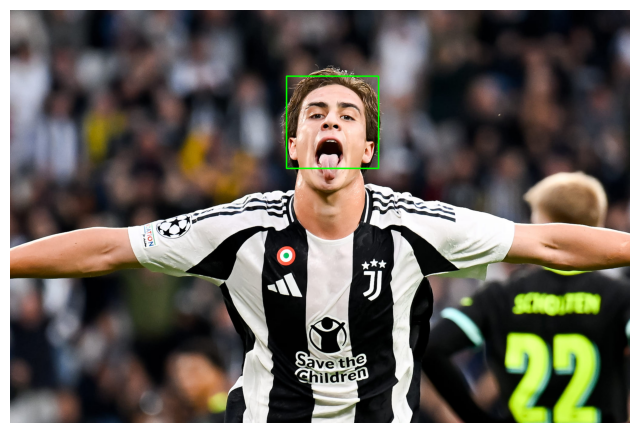

In [14]:
# Load an image.
img_path = '/content/yildiz.jpg'
img = cv2.imread(img_path)

# Check if the image was loaded correctly.
if img is None:
    print(f"Error: Could not load image from {img_path}. Please check the path.")
else:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detect_faces(img, gray)

    # Check if faces were detected
    if len(faces) == 0:
        print("No faces detected in the image.")
    else:
        print("Faces detected:", faces)
        # Draw rectangles around detected faces
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display the image
        plt.figure(figsize=(8, 6))
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.savefig("kenan_yildiz.png")
        plt.show()

In [15]:
# Function to get cropped face image if at least 2 eyes (or a side profile face) are detected
def get_cropped_image_if_2_eyes(image_path):
    """
    Reads an image, detects faces using multiple cascades, and checks for at least two eyes.
    If two eyes are found for frontal faces OR any face is found for profile faces, the cropped face is returned.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = detect_faces(img, gray)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        roi_color = img[y:y + h, x:x + w]

        # Detect eyes for frontal faces
        eyes = eye_cascade.detectMultiScale(roi_gray)

        # If two or more eyes are found, it's a frontal face
        if len(eyes) >= 2:
            return roi_color

        # If only one face is detected and it's from the profile cascade, return the cropped image
        elif len(faces) == 1:
            return roi_color

    return None  # No valid face detected

In [16]:
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [17]:
# Process all images and save cropped faces
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []

    for entry in os.scandir(img_dir):
        if entry.is_file() and entry.name.lower().endswith(('.png', '.jpg', '.jpeg')):
            roi_color = get_cropped_image_if_2_eyes(entry.path)

            if roi_color is not None:
                cropped_folder = os.path.join(path_to_cr_data, celebrity_name)

                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)

                # Append to list of cropped image directories
                cropped_image_dirs.append(cropped_folder)
                cropped_file_name = f"{celebrity_name}{count}.png"
                cropped_file_path = os.path.join(cropped_folder, cropped_file_name)

                cv2.imwrite(cropped_file_path, roi_color)
                celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
                count += 1

print("Directories with cropped images:", cropped_image_dirs)

Directories with cropped images: ['/content/dataset/dataset1/cropped/andreas_iniesta', '/content/dataset/dataset1/cropped/andreas_iniesta', '/content/dataset/dataset1/cropped/andreas_iniesta', '/content/dataset/dataset1/cropped/andreas_iniesta', '/content/dataset/dataset1/cropped/andreas_iniesta', '/content/dataset/dataset1/cropped/andreas_iniesta', '/content/dataset/dataset1/cropped/andreas_iniesta', '/content/dataset/dataset1/cropped/andreas_iniesta', '/content/dataset/dataset1/cropped/andreas_iniesta', '/content/dataset/dataset1/cropped/andreas_iniesta', '/content/dataset/dataset1/cropped/andreas_iniesta', '/content/dataset/dataset1/cropped/andreas_iniesta', '/content/dataset/dataset1/cropped/andreas_iniesta', '/content/dataset/dataset1/cropped/andreas_iniesta', '/content/dataset/dataset1/cropped/andreas_iniesta', '/content/dataset/dataset1/cropped/andreas_iniesta', '/content/dataset/dataset1/cropped/andreas_iniesta', '/content/dataset/dataset1/cropped/andreas_iniesta', '/content/da

In [18]:
# Path to the folder you want to download
folder_path = '/content/dataset/dataset1'

# Path for the output zip file
output_zip_path = '/content/dataset/dataset1'

# Compress the folder into a .zip file
shutil.make_archive(folder_path, 'zip', folder_path)

'/content/dataset/dataset1.zip'

In [19]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'andreas_iniesta': ['/content/dataset/dataset1/cropped/andreas_iniesta/andreas_iniesta19.png',
  '/content/dataset/dataset1/cropped/andreas_iniesta/andreas_iniesta173.png',
  '/content/dataset/dataset1/cropped/andreas_iniesta/andreas_iniesta122.png',
  '/content/dataset/dataset1/cropped/andreas_iniesta/andreas_iniesta91.png',
  '/content/dataset/dataset1/cropped/andreas_iniesta/andreas_iniesta39.png',
  '/content/dataset/dataset1/cropped/andreas_iniesta/andreas_iniesta156.png',
  '/content/dataset/dataset1/cropped/andreas_iniesta/andreas_iniesta77.png',
  '/content/dataset/dataset1/cropped/andreas_iniesta/andreas_iniesta17.png',
  '/content/dataset/dataset1/cropped/andreas_iniesta/andreas_iniesta42.png',
  '/content/dataset/dataset1/cropped/andreas_iniesta/andreas_iniesta114.png',
  '/content/dataset/dataset1/cropped/andreas_iniesta/andreas_iniesta25.png',
  '/content/dataset/dataset1/cropped/andreas_iniesta/andreas_iniesta146.png',
  '/content/dataset/dataset1/cropped/andreas_iniesta

In [20]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'andreas_iniesta': 0,
 'cristiano_ronaldo': 1,
 'diego_maradona': 2,
 'ronaldinho': 3,
 'roberto_baggio': 4,
 'luka_modric': 5,
 'lionel_messi': 6,
 'zlatan_ibrahimovic': 7,
 'mohamed_salah': 8,
 'riyan_giggs': 9}

In [21]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

/usr/local/lib/python3.11/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [22]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(1923, 4096)

# Training SVM, Random Forest and Logistic Regression


In [90]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [91]:
# Model Training Pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', svm.SVC(kernel='rbf', C=10))
])
pipe.fit(X_train, y_train)
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.77      0.77        56
           1       0.66      0.66      0.66        44
           2       0.76      0.65      0.70        52
           3       0.62      0.56      0.59        43
           4       0.73      0.79      0.76        58
           5       0.86      0.78      0.82        41
           6       0.66      0.84      0.74        44
           7       0.64      0.68      0.66        50
           8       0.68      0.76      0.72        51
           9       0.69      0.52      0.59        42

    accuracy                           0.71       481
   macro avg       0.71      0.70      0.70       481
weighted avg       0.71      0.71      0.71       481



In [92]:
# Hyperparameter Tuning
param_grid = {'svc__C': [0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best C:", grid.best_params_['svc__C'])
print("Best score:", grid.best_score_)
print("Test score:", grid.score(X_test, y_test))

Best C: 10
Best score: 0.6941488850442138
Test score: 0.7068607068607069


In [93]:
# Reshape and Normalize Data
X = np.array(X).reshape(len(X), -1).astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [94]:
# Model Comparison
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto', probability=True),
        'params': {'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['rbf', 'linear']}
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {'randomforestclassifier__n_estimators': [1, 5, 10]}
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {'logisticregression__C': [1, 5, 10]}
    }
}

In [95]:
scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5)
    clf.fit(X_train, y_train)
    scores.append({'model': algo, 'best_score': clf.best_score_, 'best_params': clf.best_params_})
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores)
print(df)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

                 model  best_score  \
0                  svm    0.694149   
1        random_forest    0.412606   
2  logistic_regression    0.594312   

                                    best_params  
0          {'svc__C': 10, 'svc__kernel': 'rbf'}  
1  {'randomforestclassifier__n_estimators': 10}  
2                  {'logisticregression__C': 1}  


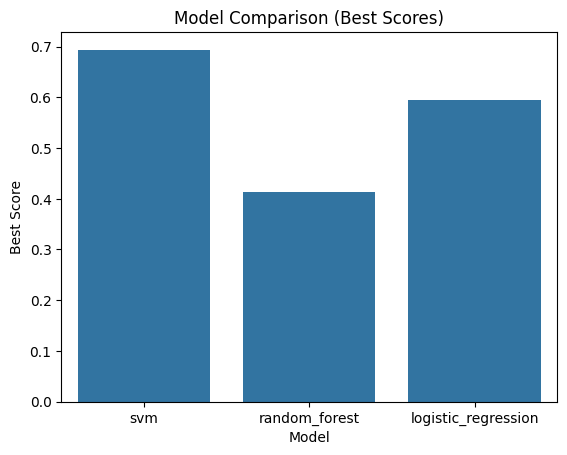

In [96]:
sns.barplot(x='model', y='best_score', data=df)
plt.title('Model Comparison (Best Scores)')
plt.xlabel('Model')
plt.ylabel('Best Score')
plt.savefig('ml_model_comparison.png')
plt.show()

In [97]:
# Model Evaluation
for model_name, estimator in best_estimators.items():
    print(f"{model_name} test score:", estimator.score(X_test, y_test))

svm test score: 0.7068607068607069
random_forest test score: 0.4594594594594595
logistic_regression test score: 0.6382536382536382


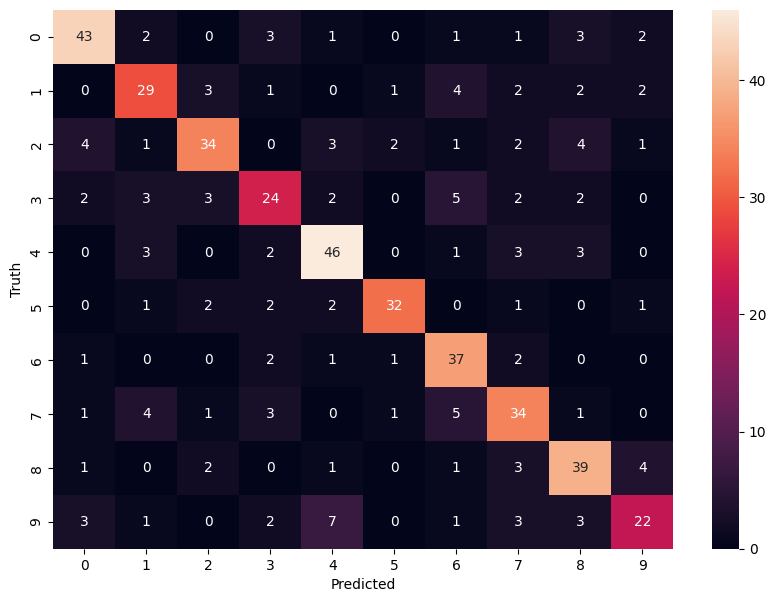

In [98]:
# Confusion Matrix for Best Model
best_clf = best_estimators['svm']
cm = confusion_matrix(y_test, best_clf.predict(X_test))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('svm_best_confusion_matrix.png')
plt.show()

# CNN

In [23]:
# Load and Preprocess Images
X = []
y = []

for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)

        # Resize raw image
        resized_img = cv2.resize(img, (32, 32))

        # Convert to grayscale
        resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

        # Apply wavelet transform
        img_har = w2d(img, 'db1', 5)
        resized_har = cv2.resize(img_har, (32, 32))

        # Stack features
        combined_img = np.dstack([resized_img, resized_har])

        # For raw image input only:
        X.append(resized_img)
        y.append(class_dict[celebrity_name])

In [24]:
# Prepare Data for Training
X = np.array(X)
y = np.array(y)

# Normalize pixel values to the range [0, 1]
X = X / 255.0
# One-hot encode labels
y = to_categorical(y, num_classes=len(class_dict))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Reshape to include channel dimension:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

In [25]:
# Build the CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_dict), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
# Compile the Model
cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Model
history = cnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the Model
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.1118 - loss: 2.2995 - val_accuracy: 0.1455 - val_loss: 2.2483
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.1757 - loss: 2.2475 - val_accuracy: 0.2883 - val_loss: 2.0425
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2980 - loss: 2.0050 - val_accuracy: 0.3610 - val_loss: 1.8464
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3233 - loss: 1.9241 - val_accuracy: 0.4026 - val_loss: 1.6961
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3666 - loss: 1.7986 - val_accuracy: 0.5247 - val_loss: 1.5685
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4371 - loss: 1.6113 - val_accuracy: 0.5636 - val_loss: 1.4687
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4888 - loss: 1.5035 - val_accuracy: 0.5403 - val_loss: 1.4150
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5405 - loss: 1.4116 - val_accuracy: 0.

In [27]:
# Generate CNN Predictions
cnn_predictions = cnn_model.predict(X_test)  # Get class probabilities
cnn_predictions = np.argmax(cnn_predictions, axis=1)  # Convert to class labels
cnn_true_labels = np.argmax(y_test, axis=1)  # True class labels

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


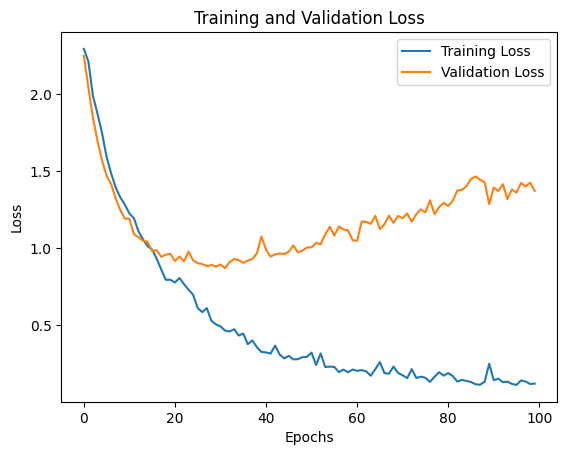

In [28]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('cnn_loss.png')
plt.show()

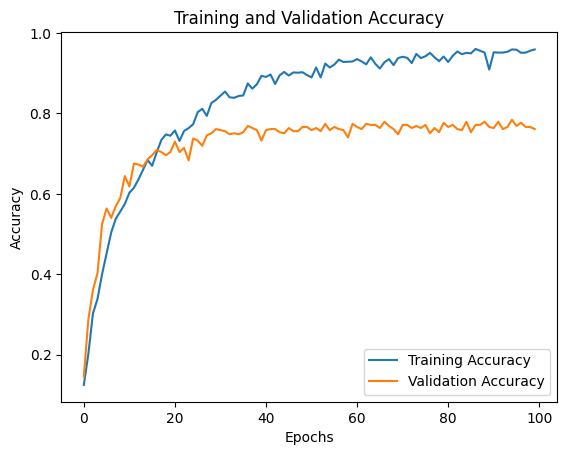

In [29]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('cnn_acc')
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


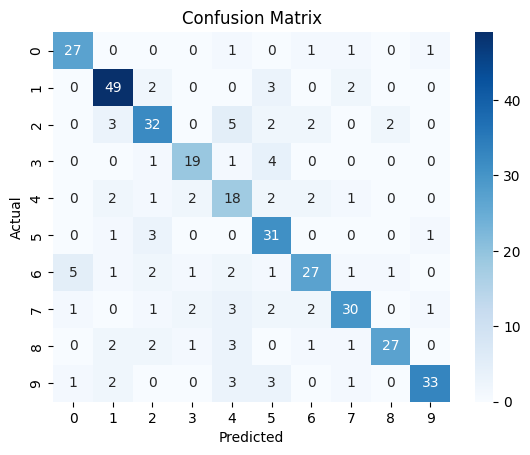

In [30]:
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('cnn_matrix')
plt.show()

# Dataset Class

In [35]:
# Create a Custom Dataset Class
class CelebrityDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Convert the image to PIL format, necessary for applying transforms
        image = Image.fromarray(image)

        # Apply transformations (resize and normalization)
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Function for Evaluating Models

In [36]:
def evaluate_model(model, test_loader, criterion, device, model_name="Model"):

    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store labels for metrics
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total


    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return y_true, y_pred, test_loss, test_accuracy


#AlexNet

In [37]:
# Prepare Data and Transformations
image_paths = []
labels = []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        image_paths.append(training_image)
        labels.append(class_dict[celebrity_name])

In [38]:
# Define transformations with augmentations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [39]:
torch.manual_seed(42)

# Define split ratios
train_ratio = 0.7  # 70% for training
val_ratio = 0.15   # 15% for validation
test_ratio = 0.15  # 15% for testing

# Compute split sizes
dataset = CelebrityDataset(image_paths, labels)
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size  # Ensure all data is used

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Assign transforms
train_dataset.dataset.transform = train_transform  # Apply augmentations to train dataset
val_dataset.dataset.transform = val_transform  # No augmentations for validation
test_dataset.dataset.transform = val_transform  # Same transform for test set

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)  # Validation set
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print dataset sizes
print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")


Train size: 1346, Validation size: 288, Test size: 289


In [40]:
# Load pre-trained AlexNet
alexnet_model = models.alexnet(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 104MB/s] 


In [41]:
# Print the names of each layer block
for name, layer in alexnet_model.named_children():
    print(name)

features
avgpool
classifier


In [42]:
# Freeze all layers initially
for param in alexnet_model.parameters():
    param.requires_grad = False

# Unfreeze the last 3 convolutional layers
for param in alexnet_model.features[-3:].parameters():
    param.requires_grad = True

# Unfreeze the last 3 fully connected layers
for param in alexnet_model.classifier[-3:].parameters():
    param.requires_grad = True

# Replace the final classification layer
num_classes = 10  # Number of players
alexnet_model.classifier[6] = nn.Linear(alexnet_model.classifier[6].in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_model = alexnet_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, alexnet_model.parameters()), lr=0.001,weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [43]:
# Training loop
best_val_loss = float('inf')
patience = 3  # Number of epochs to wait before stopping
epochs_no_improve = 0

for epoch in range(20):  # Number of epochs
    alexnet_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = alexnet_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation loop
    alexnet_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = alexnet_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = 100 * correct / total

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss}, Accuracy: {val_accuracy}%')

    # Learning rate scheduler step
    scheduler.step()

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(alexnet_model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping!")
            break

Epoch 1, Loss: 1.8212221117580638, Validation Loss: 1.384442599196183, Accuracy: 60.416666666666664%
Epoch 2, Loss: 1.1785146699232214, Validation Loss: 1.2652731569189775, Accuracy: 70.83333333333333%
Epoch 3, Loss: 1.0043230708907633, Validation Loss: 1.073369954761706, Accuracy: 77.77777777777777%
Epoch 4, Loss: 0.8502236338222728, Validation Loss: 1.0335694331871836, Accuracy: 81.25%
Epoch 5, Loss: 0.7992574046639835, Validation Loss: 0.9989645826189142, Accuracy: 82.29166666666667%
Epoch 6, Loss: 0.6730519301751081, Validation Loss: 0.9649270239629244, Accuracy: 83.33333333333333%
Epoch 7, Loss: 0.6426402996568119, Validation Loss: 0.9671416094428614, Accuracy: 82.29166666666667%
Epoch 8, Loss: 0.6293329098645378, Validation Loss: 0.9592077481119257, Accuracy: 82.98611111111111%
Epoch 9, Loss: 0.6205112541423125, Validation Loss: 0.957025336591821, Accuracy: 83.33333333333333%
Epoch 10, Loss: 0.6027136157540715, Validation Loss: 0.9546531627052709, Accuracy: 84.02777777777777%
Epo

In [44]:
y_true_alex, y_pred_alex, test_loss_alex, accuracy_alex = evaluate_model(alexnet_model, test_loader, criterion, device, model_name="AlexNet")

Test Loss: 0.9883, Test Accuracy: 86.16%


# EfficientNet Model

In [45]:
# Prepare Data and Transformations
image_paths = []
labels = []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        image_paths.append(training_image)
        labels.append(class_dict[celebrity_name])

In [46]:
# Define transformations with augmentations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally
    transforms.RandomRotation(10),  # Rotate images up to 10 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small translations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Change brightness & contrast
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [47]:
torch.manual_seed(42)

# Define split ratios
train_ratio = 0.7  # 70% for training
val_ratio = 0.15   # 15% for validation
test_ratio = 0.15  # 15% for testing

# Compute split sizes
dataset = CelebrityDataset(image_paths, labels)
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size  # Ensure all data is used

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Assign transforms
train_dataset.dataset.transform = train_transform  # Apply augmentations to train dataset
val_dataset.dataset.transform = val_transform  # Apply transform for validation
test_dataset.dataset.transform = val_transform  # Same transform for test set

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print dataset sizes
print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

Train size: 1346, Validation size: 288, Test size: 289


In [48]:
# Load pre-trained EfficientNet-B0
efnet_model = models.efficientnet_b0(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 107MB/s] 


In [49]:
# Print the names of each layer block
for name in efnet_model.features.children():
    print(name)

Conv2dNormActivation(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)
Sequential(
  (0): MBConv(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): SqueezeExcitation(
        (avgpool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (activation): SiLU(inplace=True)
        (scale_activation): Sigmoid()
      )
      (2): Conv2dNormActivation(
        (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, 

In [50]:
# Freeze all layers initially
for param in efnet_model.parameters():
    param.requires_grad_(False)

# Unfreeze the last 30% of the layers
total_layers = len(list(efnet_model.features.children()))
for i, layer in enumerate(efnet_model.features.children()):
    if i > 0.6 * total_layers:  # Unfreeze the last 30% of layers
        for param in layer.parameters():
            param.requires_grad = True

# Modify Fully Connected (FC) Layer
num_classes = 10  # Number of football players
efnet_model.classifier[1] = nn.Linear(efnet_model.classifier[1].in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efnet_model = efnet_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, efnet_model.parameters()), lr=0.001,weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [51]:
# Training loop
best_val_loss = float('inf')
patience = 3  # Number of epochs to wait before stopping
epochs_no_improve = 0

for epoch in range(20):  # Number of epochs
    efnet_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = efnet_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    # Validation loop
    efnet_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = efnet_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = 100 * correct / total

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss}, Accuracy: {val_accuracy}%')

    # Learning rate scheduler step
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(efnet_model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping!")
            break

Epoch 1, Loss: 1.8199427398768337, Validation Loss: 1.328829002380371, Accuracy: 68.5121107266436%
Epoch 2, Loss: 1.0049081173810093, Validation Loss: 1.0515499353408813, Accuracy: 79.23875432525952%
Epoch 3, Loss: 0.8176520060409199, Validation Loss: 0.9899266123771667, Accuracy: 83.04498269896193%
Epoch 4, Loss: 0.7129735729911111, Validation Loss: 0.985493516921997, Accuracy: 83.04498269896193%
Epoch 5, Loss: 0.6757566603747281, Validation Loss: 0.9950667023658752, Accuracy: 83.04498269896193%
Epoch 6, Loss: 0.688314985145222, Validation Loss: 0.9641873240470886, Accuracy: 85.46712802768167%
Epoch 7, Loss: 0.657265077937733, Validation Loss: 0.9730578660964966, Accuracy: 84.42906574394463%
Epoch 8, Loss: 0.6592490185390819, Validation Loss: 0.933430302143097, Accuracy: 85.46712802768167%
Epoch 9, Loss: 0.6524080986326392, Validation Loss: 0.9717655897140502, Accuracy: 84.08304498269896%
Epoch 10, Loss: 0.6186776513403113, Validation Loss: 0.9666319131851197, Accuracy: 85.81314878892

In [52]:
y_true_ef, y_pred_ef, test_loss_ef, accuracy_ef = evaluate_model(efnet_model, test_loader, criterion, device, model_name="EfNet")

Test Loss: 0.9409, Test Accuracy: 85.12%


#ResNet Model

In [53]:
# Prepare Data and Transformations
image_paths = []
labels = []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        image_paths.append(training_image)
        labels.append(class_dict[celebrity_name])

In [54]:
 # Define transformations with augmentations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),  # Rotate up to 15 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small random shifts
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [55]:
torch.manual_seed(42)
# Define split ratios
train_ratio = 0.7  # 70% for training
val_ratio = 0.15   # 15% for validation
test_ratio = 0.15  # 15% for testing

# Compute split sizes
dataset = CelebrityDataset(image_paths, labels)
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size  # Ensure all data is used

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Assign transforms
train_dataset.dataset.transform = train_transform  # Apply augmentations to train dataset
val_dataset.dataset.transform = val_transform  # Apply transform for validation
test_dataset.dataset.transform = val_transform  # Same transform for test set

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)  # Validation set
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print dataset sizes
print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

Train size: 1346, Validation size: 288, Test size: 289


In [56]:
# Load pre-trained ResNet50
resnet_model = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


In [57]:
# Print the names of each layer block
for name, layer in resnet_model.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [58]:
# Freeze layers up to layer3
for name, layer in resnet_model.named_children():
    if name in ['conv1', 'bn1', 'layer1', 'layer2']:
        for param in layer.parameters():
            param.requires_grad = False
    else:
      for param in layer.parameters():
            param.requires_grad = True

# Replace the final fully connected layer
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 10)  # 10 output classes

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

# Print model summary
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [59]:
#Checking if correctly unfreezed the last layers
for name, param in resnet_model.named_parameters():
    print(f"Layer: {name} | Trainable: {param.requires_grad}")

Layer: conv1.weight | Trainable: False
Layer: bn1.weight | Trainable: False
Layer: bn1.bias | Trainable: False
Layer: layer1.0.conv1.weight | Trainable: False
Layer: layer1.0.bn1.weight | Trainable: False
Layer: layer1.0.bn1.bias | Trainable: False
Layer: layer1.0.conv2.weight | Trainable: False
Layer: layer1.0.bn2.weight | Trainable: False
Layer: layer1.0.bn2.bias | Trainable: False
Layer: layer1.0.conv3.weight | Trainable: False
Layer: layer1.0.bn3.weight | Trainable: False
Layer: layer1.0.bn3.bias | Trainable: False
Layer: layer1.0.downsample.0.weight | Trainable: False
Layer: layer1.0.downsample.1.weight | Trainable: False
Layer: layer1.0.downsample.1.bias | Trainable: False
Layer: layer1.1.conv1.weight | Trainable: False
Layer: layer1.1.bn1.weight | Trainable: False
Layer: layer1.1.bn1.bias | Trainable: False
Layer: layer1.1.conv2.weight | Trainable: False
Layer: layer1.1.bn2.weight | Trainable: False
Layer: layer1.1.bn2.bias | Trainable: False
Layer: layer1.1.conv3.weight | Train

In [60]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# Define optimizer (only for the classifier layer)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=0.001,weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [61]:
# Number of epochs
epochs = 20

# Training loop
for epoch in range(epochs):
    resnet_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

    # Validation loop
    resnet_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step()


    print(f'Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%')

Epoch 1/20, Loss: 1.6137810186906294
Validation Loss: 7.041302680969238, Accuracy: 39.236111111111114%
Epoch 2/20, Loss: 1.0681005120277405
Validation Loss: 1.5402610301971436, Accuracy: 61.458333333333336%
Epoch 3/20, Loss: 0.9668646265159954
Validation Loss: 1.3576620817184448, Accuracy: 67.36111111111111%
Epoch 4/20, Loss: 0.8785791424187747
Validation Loss: 1.2197336673736572, Accuracy: 70.83333333333333%
Epoch 5/20, Loss: 0.8773838877677917
Validation Loss: 1.2790126085281373, Accuracy: 73.95833333333333%
Epoch 6/20, Loss: 0.7706711996685375
Validation Loss: 1.0637382507324218, Accuracy: 81.94444444444444%
Epoch 7/20, Loss: 0.6460573889992454
Validation Loss: 1.0232150316238404, Accuracy: 83.33333333333333%
Epoch 8/20, Loss: 0.6386499106884003
Validation Loss: 0.9971836805343628, Accuracy: 84.72222222222223%
Epoch 9/20, Loss: 0.617870035496625
Validation Loss: 1.0021088480949403, Accuracy: 82.98611111111111%
Epoch 10/20, Loss: 0.6048769463192333
Validation Loss: 0.9789417147636413

In [62]:
y_true_res, y_pred_res, test_loss_res, accuracy_res = evaluate_model(resnet_model, test_loader, criterion, device, model_name="ResNet")

Test Loss: 1.0062, Test Accuracy: 85.81%


# Comparing Models

In [63]:
# Define function to calculate and display metrics
def calculate_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"{model_name} Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")

    return accuracy, precision, recall, f1

In [64]:
# Compute metrics for all models
#cnn_metrics = calculate_metrics(np.argmax(y_test, axis=1), cnn_predictions, "CNN")
alexnet_metrics = calculate_metrics(y_true_alex, y_pred_alex, "AlexNet")
efnet_metrics = calculate_metrics(y_true_ef, y_pred_ef, "EfNet")
resnet_metrics = calculate_metrics(y_true_res, y_pred_res, "ResNet")

AlexNet Metrics:
  Accuracy: 0.8616
  Precision: 0.8647
  Recall: 0.8616
  F1-score: 0.8613
EfNet Metrics:
  Accuracy: 0.8512
  Precision: 0.8558
  Recall: 0.8512
  F1-score: 0.8519
ResNet Metrics:
  Accuracy: 0.8581
  Precision: 0.8618
  Recall: 0.8581
  F1-score: 0.8579


In [65]:
# Visualize the results in a bar chart
metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
models = ['AlexNet', 'EfNet', 'ResNet']
metrics_values = [
    [alexnet_metrics[0], efnet_metrics[0], resnet_metrics[0]],
    [alexnet_metrics[1], efnet_metrics[1], resnet_metrics[1]],
    [alexnet_metrics[2], efnet_metrics[2], resnet_metrics[2]],
    [alexnet_metrics[3], efnet_metrics[3], resnet_metrics[3]]
]

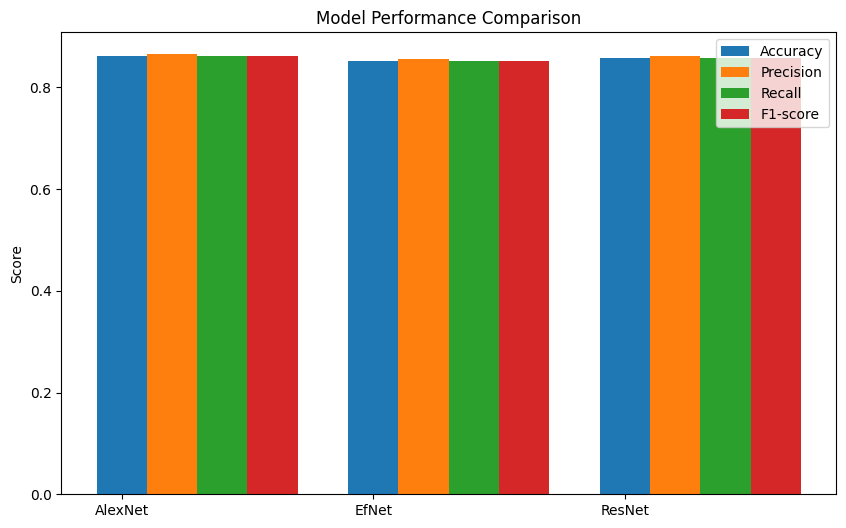

In [72]:
# Create bar plots for comparison
plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics_labels):
    plt.bar([x + i * 0.2 for x in range(len(models))], metrics_values[i], width=0.2, label=metric)

plt.xticks(range(len(models)), models)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.savefig("model_comparison.png")
plt.show()

In [79]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_dict.keys(), yticklabels=class_dict.keys())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.show()

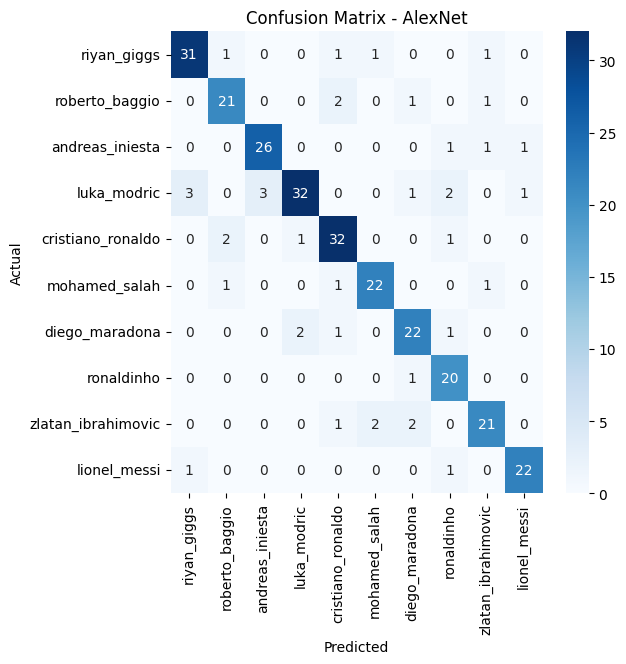

In [80]:
plot_confusion_matrix(y_true_alex, y_pred_alex, "AlexNet")

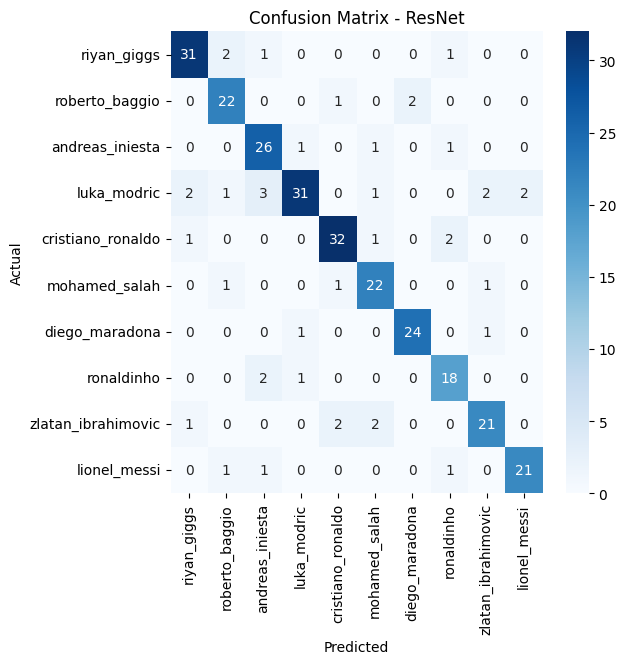

In [81]:
plot_confusion_matrix(y_true_res, y_pred_res, "ResNet")

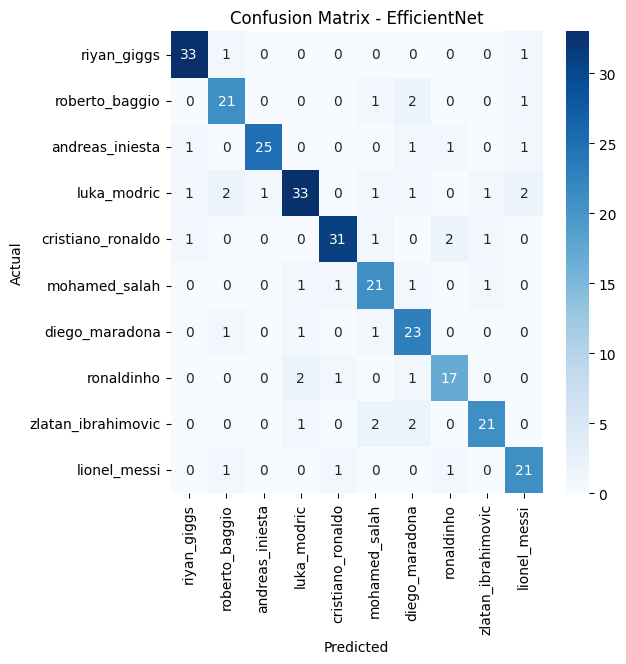

In [82]:
plot_confusion_matrix(y_true_ef, y_pred_ef, "EfficientNet")